# SMS SPAM Classifier 

In [1]:
# import
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Evaluate Model 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score 

from sklearn.linear_model import LogisticRegression

In [ ]:
# If document is implemented in google colab
## google colab specific 
#!unzip 'smsspamcollection.zip' -d ''

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

#pip install gensim==4.0.1
#pip install scikit-learn==0.24.2

## Load the DATA

In [2]:
# load the sms data 
data = pd.read_csv('smsspamcollection/spam.csv',encoding=('ISO-8859-1'),usecols=[0,1])
data.columns = ['label','message']

In [249]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##  Data Exploration

In [4]:
# Total messages 
data.shape

(5572, 2)

In [5]:
# show five random messages from the dataset 

index = np.random.randint(0,data.shape[0]-5)
print(data[index:index+5])

     label                                            message
4998   ham                         Hmph. Go head, big baller.
4999   ham  Well its not like you actually called someone ...
5000   ham  Nope. Since ayo travelled, he has forgotten hi...
5001   ham         You still around? Looking to pick up later
5002  spam  CDs 4u: Congratulations ur awarded å£500 of CD...


In [251]:
data.loc[5002,'message']

'CDs 4u: Congratulations ur awarded å£500 of CD gift vouchers or å£125 gift guaranteed & Freeentry 2 å£100 wkly draw xt MUSIC to 87066 TnCs www.ldew.com1win150ppmx3age16 '

In [6]:
# Check the label distribution
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

## Data Preprocessing 

In [234]:
def clean_sentence(message):
    '''
    Function to preprocess the sentence
    Input : message in string format
    
    Return : Preprocessed and cleaned string
    '''
    
    lemmatizer = WordNetLemmatizer()
    # Remove all the words execpt words and numbers
    review = re.sub('[^a-zA-Z]',' ',message)
    
    # convert to lower case 
    review =review.lower()
    
    # Tokenize words
    words = nltk.word_tokenize(review)
    
    # remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    
    # rejoin 
    review = ' '.join(words)
    
    return review
    

In [8]:
# Clean the data 
clean_data = data.copy()
clean_data.message = clean_data.message.apply(clean_sentence)

# Model Building 

### Helper functions 

In [207]:
def evaluate_model(model,X_test,y_test,threshold=None,plots =True):
    
    '''
    Function evaluates the Model on various evaluation metrics 
    Inputs :model - sklearn model
            X_test - Data on which Model to be evaluated, numpy array(m,n) 
            y_test - labels numpy array of shape (m,1)
            thresholds - if provided, predictions are calculated based on this threshold
                         Note : applicable only for the models with model.predict_proba
            plots - boolean , when True plots ROC and Precision recall curve
            
    Returns : accuracy, precision, recall, fscore, roc_auc
    '''
    
    from sklearn import metrics
    import matplotlib.pyplot as plt
    
    # get the prediction probabilities 
    y_pred_proba = model.predict_proba(X_test)[:,1] 
    
    if threshold is None:
        y_pred = model.predict(X_test) # with default threshold of 0.5
    else:
        y_pred = np.where(y_pred_proba>threshold,1,0)
    
    # confusion Matrix 
    confusion_matrix =metrics.confusion_matrix(y_test,y_pred)
    
    # Accuracy
    accuracy = accuracy_score(y_test,y_pred)
    
    # precision, Recall, F1 score 
    precision,recall,fscore,support = metrics.precision_recall_fscore_support(y_test,y_pred)
    
    # ROC AUC 
    roc_auc = metrics.roc_auc_score(y_test,y_pred_proba)
    
    if plots:
        # Print to output
        
        print('Accuracy  : {}'.format(accuracy))
        print('precision : {}'.format(precision[1]))
        print('recall    : {}'.format(recall[1]))
        print('f1score    : {}'.format(fscore[1]))
        print('roc_auc   : {}'.format(roc_auc))
        
        fig=plt.figure(figsize=(15,4))
        if threshold is None:
            fig.suptitle('Classification Report',fontweight ="bold")
        else:
            fig.suptitle('Classification Report with threshold = {}'.format(round(threshold,2)),fontweight ="bold")
        
        # Confusion Matrix         
        #plt.suptitle('Classification Report',fontsize=20)        
        fig =plt.subplot(1,3,1)        
        sns.heatmap(confusion_matrix,annot=True,fmt='')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        #metrics.plot_confusion_matrix(model,X_test,y_test,ax=fig)
        
        # ROC Curve 
        fig =plt.subplot(1,3,2)
        plt.title('ROC Curve')
        s =metrics.plot_roc_curve(model,X_test,y_test,name ='ROC Curve',ax=fig)
        
        # Precision Recall curve
        fig =plt.subplot(1,3,3)
        metrics.plot_precision_recall_curve(model,X_test,y_test,name='Precision Recall Curve',ax=fig)
        
        if threshold is not None:
            plt.scatter(x=precision[1],y=recall[1],c='coral',s=100)
            plt.text(x=precision[1]-0.33,y=recall[1]-0.1, 
             s= 'Threshold :{}'.format(round(threshold,2)),
            bbox=dict(facecolor='yellow',alpha=0.5))
            
        plt.title('Precision Recall Curve')
        plt.xlabel('Precision (positive label :1)')
        plt.ylabel('Recall (positive label :1)')
        
        
        
        
    
    return {'accuracy':accuracy,
            'precision':precision[1],
            'recall':recall[1],
            'f1_score':fscore[1],
            'roc_auc':roc_auc}



In [209]:
def get_best_thresholds(model,X_test,y_test,plots =True):
    '''
    Function finds the optimum value of Threshold using ROC and Precision Recall curves and F1 scores
    Inputs :model - sklearn model
            X_test - Data on which Model to be evaluated, numpy array(m,n) 
            y_test - labels numpy array of shape (m,1)
            
    Returns : Thresholds in tupple format(optimized_threshold_roc,optimized_threshold_pr,optimized_threshold_f1)
            

    '''
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get the prediction probabilities 
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    #=================================================================
    
    # Get False postive rate fpr, True Positive rate ,tpr and Thresholds 
    fpr,tpr,thresholds =metrics.roc_curve(y_test,y_pred_proba)
    
    # Get the threshold which gives best accuracy 
    accuray_list=[]
    
    for thres in thresholds:
        # predict based on threshold
        y_pred = np.where(y_pred_proba>thres,1,0)
        
        #calculate and append accuracy scores
        accuray_list.append(metrics.accuracy_score(y_test,y_pred))
        
    # Get the index of maximum accuracy 
    max_acc_index = np.array(accuray_list).argmax()
    
    # Get optimed Threshold 
    optimized_threshold_roc = thresholds[max_acc_index]
    
    opti_fpr = fpr[max_acc_index]
    opti_tpr = tpr[max_acc_index]
    
    # Plot ROC curve and highlight the optimum value 
    fig=plt.figure(figsize=(15,4))
    fig.suptitle('Best Thresholds for Accuracy, Precision and F1 score',fontweight ="bold")
    
    plt.subplot(1,3,1)
    sns.lineplot(x=fpr,y=tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Poitive Rate FPR (positive label :1)')
    plt.ylabel('False Poitive Rate FPR (positive label :1)')
    # Add optimized point in the plot
    plt.scatter(x=opti_fpr,y=opti_tpr,c='coral',s=100)
    plt.text(x=opti_fpr+0.04,y=opti_tpr-0.03, 
             s= 'Threshold :{}'.format(round(optimized_threshold_roc,2)),
            bbox=dict(facecolor='yellow',alpha=0.5))
    #========================================================================
    # Get Optimul Threshold using Precision - Recall curve
    
    # Get Precision, recall,and Thresholds 
    precision,recall,thresholds_pr = metrics.precision_recall_curve(y_test,y_pred_proba)
    
    # accuracies for different thresholds 
    accuracy_list_pr =[]
    
    for thres in thresholds_pr:
        
        y_pred_pr = np.where(y_pred_proba>thres,1,0)
        #calculate and append accuracy scores
        accuracy_list_pr.append(metrics.accuracy_score(y_test,y_pred_pr))
        
    # Get the index of maximum accuracy 
    max_acc_index_pr = np.array(accuracy_list_pr).argmax()
    
    # Get optimed Threshold 
    optimized_threshold_pr = thresholds_pr[max_acc_index_pr]
    
    opti_precision = precision[max_acc_index_pr]
    opti_recall = recall[max_acc_index_pr]
    
    # Plot Precision Recall  curve and highlight the optimum value 
    plt.subplot(1,3,2)
    sns.lineplot(x=precision,y=recall,color='green')
    # Add reference line of a Dummy Classifier
    #
    plt.title('Precision Recall Curve')
    plt.xlabel('Precision (positive label :1)')
    plt.ylabel('Recall (positive label :1)')
    # Add optimized point in the plot
    plt.scatter(x=opti_precision,y=opti_recall,c='coral',s=100)
    plt.text(x=opti_precision-0.33,y=opti_recall-0.03, 
             s= 'Threshold :{}'.format(round(optimized_threshold_pr,2)),
            bbox=dict(facecolor='yellow',alpha=0.5))
    
    #=====================================================================
    # caluculate the best f1 scores 
    f1_scores = 2*np.multiply(precision,recall)/(precision +recall)
    best_f1score_index = f1_scores.argmax()
    
    best_f1_score = f1_scores[best_f1score_index]
    optimized_threshold_f1 = thresholds_pr[best_f1score_index]
    
    
    # Plot Graph f1_scores Vs Thresholds 
    plt.subplot(1,3,3)
    sns.lineplot(x=thresholds_pr,y=f1_scores[1:],color='blue')
    # Add reference line of a Dummy Classifier
    #
    plt.title('F1 Scores Vs Threshold')
    plt.xlabel('Thresold (positive label :1)')
    plt.ylabel('F1 Scores (positive label :1)')
    # Add optimized point in the plot
    plt.scatter(x=optimized_threshold_f1,y=best_f1_score,c='coral',s=100)
    plt.text(x=optimized_threshold_f1-0.33,y=best_f1_score-0.1, 
             s= 'Threshold :{}'.format(round(optimized_threshold_f1,2)),
            bbox=dict(facecolor='yellow',alpha=0.5))
    
    return optimized_threshold_roc,optimized_threshold_pr,optimized_threshold_f1



### BOW - CountVectorizer

In [11]:
# Create BOW using countvectorizer and vectorize the messages
cv = CountVectorizer(max_features=5000)
X= cv.fit_transform(clean_data.message).toarray()

# convert the label to numeric 
# spam =1 , ham =0
y=pd.get_dummies(clean_data.label)
y=y.iloc[:,1].values

# Train Test Split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

#### Naive Bayes 

In [39]:
#### Build Models
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)
y_predict = nb_model.predict(X_test)

In [40]:
# Evaluation on Training Data
training_metrics = evaluate_model(nb_model,X_train,y_train,plots=False)
# Evaluation on Testing Data
testing_metrics = evaluate_model(nb_model,X_test,y_test,plots=False)

print('Training Metrics :\n',training_metrics)
print('Testing Metrics :\n',testing_metrics)


Training Metrics :
 {'accuracy': 0.9899035225487997, 'precision': 0.9542372881355933, 'recall': 0.9690189328743546, 'f1_score': 0.9615713065755764, 'roc_auc': 0.9955198947048698}
Testing Metrics :
 {'accuracy': 0.9838565022421525, 'precision': 0.9404761904761905, 'recall': 0.9518072289156626, 'f1_score': 0.9461077844311376, 'roc_auc': 0.9894943313824317}


Accuracy  : 0.9838565022421525
precision : 0.9404761904761905
recall    : 0.9518072289156626
fscore    : 0.9461077844311376
roc_auc   : 0.9894943313824317


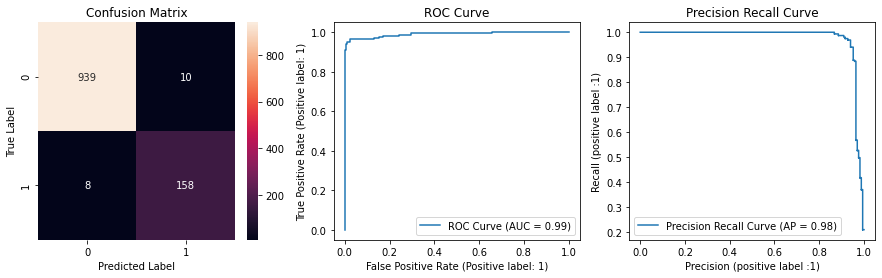

In [41]:
# Plot graphs for Test Data 
_=evaluate_model(nb_model,X_test,y_test,plots=True)

(0.5822332978181426, 0.5822332978181426, 0.6337035211485478)

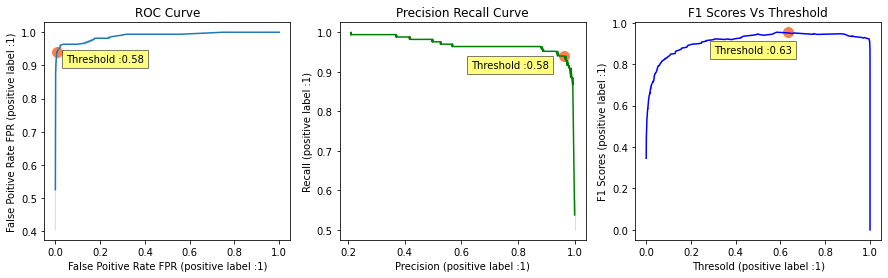

In [42]:
# Get the OPtimal Threshold for the Test Data 
get_best_thresholds(nb_model,X_test,y_test)

Accuracy  : 0.9856502242152466
precision : 0.96875
recall    : 0.9337349397590361
fscore    : 0.950920245398773
roc_auc   : 0.9894943313824317


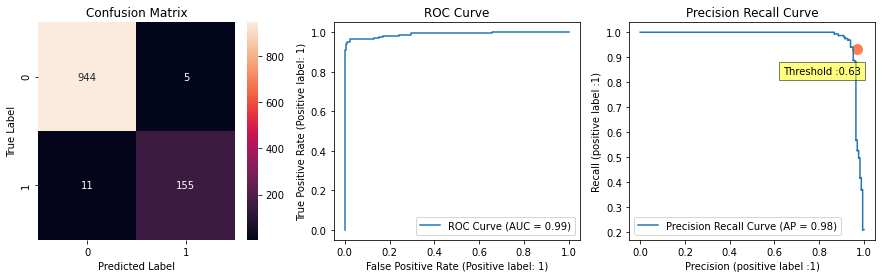

In [44]:
# Revaluate Model with OPtimised Threshold for best f1 score
_=evaluate_model(nb_model,X_test,y_test,threshold=0.6337035211485478)

### TF-IDF Vectorizer

In [47]:
# Create BOW using countvectorizer and vectorize the messages
tfidf_v = TfidfVectorizer(max_features=5000,min_df=10)
X= tfidf_v.fit_transform(clean_data.message).toarray()

# convert the label to numeric 
# spam =1 , ham =0
y=pd.get_dummies(clean_data.label)
y=y.iloc[:,1].values

# Train Test Split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

#### Naive Bayes 

In [48]:
#### Build Models
from sklearn.naive_bayes import MultinomialNB

nb_model_tf_idf = MultinomialNB()
nb_model_tf_idf.fit(X_train,y_train)
y_predict = nb_model_tf_idf.predict(X_test)

In [49]:
# Evaluation on Training Data
training_metrics = evaluate_model(nb_model_tf_idf,X_train,y_train,plots=False)
# Evaluation on Testing Data
testing_metrics = evaluate_model(nb_model_tf_idf,X_test,y_test,plots=False)

print('Training Metrics :\n',training_metrics)
print('Testing Metrics :\n',testing_metrics)

Training Metrics :
 {'accuracy': 0.982499439084586, 'precision': 0.982725527831094, 'recall': 0.8812392426850258, 'f1_score': 0.9292196007259528, 'roc_auc': 0.993050263859507}
Testing Metrics :
 {'accuracy': 0.9721973094170404, 'precision': 0.972027972027972, 'recall': 0.8373493975903614, 'f1_score': 0.8996763754045307, 'roc_auc': 0.9894086355961254}


Accuracy  : 0.9721973094170404
precision : 0.972027972027972
recall    : 0.8373493975903614
fscore    : 0.8996763754045307
roc_auc   : 0.9894086355961254


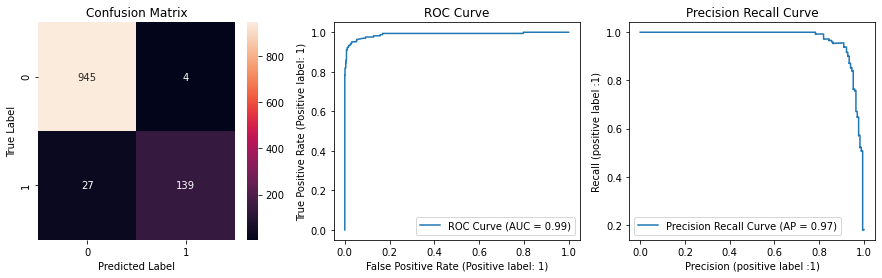

In [50]:
# Plot graphs for Test Data 
_=evaluate_model(nb_model_tf_idf,X_test,y_test,plots=True)

(0.3408590861580344, 0.32907904741680316, 0.3408590861580344)

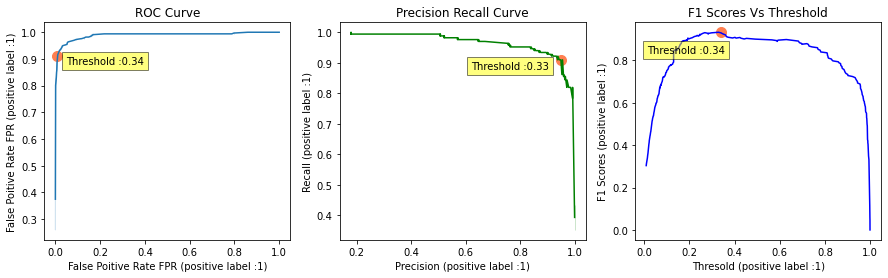

In [52]:
# Get the OPtimal Threshold for the Test Data 
get_best_thresholds(nb_model_tf_idf,X_test,y_test)

Accuracy  : 0.9802690582959641
precision : 0.9556962025316456
recall    : 0.9096385542168675
fscore    : 0.9320987654320988
roc_auc   : 0.9894086355961254


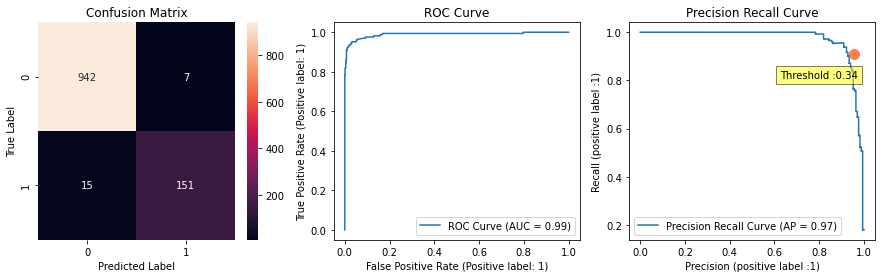

In [55]:
# Revaluate Model with OPtimised Threshold for best f1 score
_=evaluate_model(nb_model_tf_idf,X_test,y_test,threshold=0.34)

# Helper Functions : Training and Evaluating Models

###  Training Multiple Models 

In [13]:
def train_models(models,X_train,y_train,X_test,y_test):
    '''
    Function to train and test Multiple Models and give all classification metrics and trained_models
    Input : models : dictionary of models,key is modelname and value is model
    
    Returns : trained models in dictionary {model_name : trained_model}
    '''
    import pandas as pd 
    models_data = pd.DataFrame()
    trained_models = {}
    
    # Loop throug all the models 
    for model_name,model in models.items():
        
        # Fit the model to Training data
        model.fit(X_train,y_train)
        
        # Evaluate Model 
        # on Train Data
        #training_metrics = evaluate_model(model,X_train,y_train,plots=False)
        # on Test Data
        #testing_metrics = evaluate_model(model,X_test,y_test,plots=False)
        
        # Store values in the Dataframe
        # Training Metrics
        #df =pd.DataFrame([training_metrics],index=[model_name])
        # Testing Metrics         
        #df=df.merge(pd.DataFrame([testing_metrics],index=[model_name]),left_index=True,right_index=True,suffixes=('_train', '_test'))
        # Add to Models data
        #models_data=models_data.append(df)
        
        # Add Trained Models to trained_models
        trained_models[model_name] =model
    
    # Rearrange the columns of models_data_frame
    '''
    colum_names =['accuracy_train','accuracy_test', 
                  'precision_train','precision_test', 
                  'recall_train','recall_test', 
                  'f1_score_train', 'f1_score_test',
                  'roc_auc_train','roc_auc_test'
                 ]
     '''
          
    #models_data = models_data.loc[:,colum_names]
    
        
    return trained_models

### Save and Load Models - using pickle

In [71]:
def save_trained_models(models,file_name):
    '''
    Function to save models in pickle format
    Input : models - sklearn models to be saved
            file_name - file_name
    '''
    import pickle
    # if file already exist, update it 
    
    with open(file_name,'wb') as files:
        pickle.dump(models,files)
    

In [73]:
def load_trained_models(file_name):
    '''
    Function to save models 
    Input : models - sklearn models to be saved
            file_name - file_name
    
    Returns : loaded models
    '''
    import pickle
    # if file already exist, update it 
    
    # load Models 
    with open(file_name,'rb') as files:
        models = pickle.load(files)
        
    return models

### Model Evaluation 

In [44]:
def eval_model(model,X_test,y_test):
    '''
    Function to evaluate model and return classification report 
    Inputs :model - sklearn model
            X_test - Data on which Model to be evaluated, numpy array(m,n) 
            y_test - labels numpy array of shape (m,1)
                       
    Returns : accuracy, precision, recall, f1-score
    '''
    
    from sklearn.metrics import classification_report
    # Predictions
    y_pred = model.predict(X_test)
    classification_metrics = classification_report(y_test,y_pred,output_dict=True)
    
    # Create new dictionary and store only required values
    metrics =dict()
    metrics['accuracy']=classification_metrics['accuracy']
    
    for met in ['precision','recall','f1-score']:
        metrics[met] = classification_metrics['1'][met] # metrics of class 1 (SPAM)
    
    return metrics # Return the metrics 

In [188]:
def print_cv_scores_gridsearch(grid_search_cv_models):
    '''
    Function to print Cross-validation scores of Grid_sreach_CV objects 
    Input : grid_search_cv_models - Dictionary of Grid_sreach_CV Models 
    
    Returns : None 
    '''
    import pprint
    print('Grid Search results\n')
    for model_name,model in grid_search_cv_models.items():
        
        print('Model            :',model_name)
        print('Best Parameters  :',model.best_params_)
        print('Cross Validation :',model.cv)
        print('Mean Cross-validation f1-score :',model.best_score_)
        print('=====================================')
    
    

In [81]:
def print_evaluation_metrics(models,X_test,y_test):
    '''
    Function to print evaluate and print classification report of models 
    Input : models - dictionary of models (key,value) -> ('model_name',model)
            X_test - Testing data 
            y_test - Testing data labels
    '''
    import pprint
    for model_name,model in models.items():
    
        print('Classification Report')
        print('Model Name        :',model_name)
        print('Best Parameters   :',model.best_params_)
        print ('Test data metrics :')
        metrics = eval_model(model,X_test,y_test)
        pprint.pprint(metrics)
        print('==========================================')   
    

In [220]:
def print_evaluation_metrics_single(model,X_test,y_test,model_name =''):
    '''
    Function to print evaluate and print classification report of models 
    Input : models - model
            X_test - Testing data 
            y_test - Testing data labels
    '''
    import pprint
    
    print('Classification Report')
    print('Model Name        :',model_name)
    print('Best Parameters   :',model.best_params_)
    print ('Test data metrics :')
    metrics = eval_model(model,X_test,y_test)
    pprint.pprint(metrics)
    print('==========================================')  

# Model Building : Train and Evaluate

### Setting Up Models for Hyper parameter Tuning 

In [255]:
# Tune Model using Grid_search CV 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

ml_models = dict()

# Logistic_regression or Lasso rigression
lr_params = {'C':[0, 0.01,0.1, 1, 10, 100]}
lr_Grid_CV = GridSearchCV(LogisticRegression(),
                                       param_grid=lr_params,
                                       scoring='f1',
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=1
                                       )

# Naive bayes 
nb_params = {'alpha':[0, 0.01,0.1, 1, 10, 100]}
nb_Grid_CV = GridSearchCV(MultinomialNB(),
                                       param_grid=nb_params,
                                       scoring='f1',
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=1
                                       )

# SVM
svm_params = {'C':[0.01,0.1,1,10],
          'gamma':[0.01,0.1,1,10]
         }
svm_Grid_CV = GridSearchCV(SVC(),
                                       param_grid=svm_params,
                                       scoring='f1',
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=1
                                       )

ml_models['naive_bayes']= nb_Grid_CV
ml_models['logistic_regression']=lr_Grid_CV
ml_models['svm']=svm_Grid_CV

## BOW - CountVectorizer

#### Train Test split

In [231]:
# Create BOW using countvectorizer and vectorize the messages
cv = CountVectorizer(max_features=5000)
X= cv.fit_transform(clean_data.message).toarray()

# convert the label to numeric 
# spam =1 , ham =0
y=pd.get_dummies(clean_data.label)
y=y.iloc[:,1].values

# Train Test Split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [232]:
# save count_vectorizer model 
file_name = 'count_vectorizer'
save_trained_models(cv,file_name)

#### Build Model and Evaluate

In [79]:
# Train Multiple Models
trained_models_cv =train_models(ml_models,X_train,y_train,X_test,y_test)

# Save Models 
filename_cv_models= 'models_count_vect'
save_trained_models(trained_models_cv,filename_cv_models)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\harish\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.40422808 0.86543033 0.91792172 0.92605577 0.92412739]
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [186]:
# load models 
filename_cv_models= 'models_count_vect'
trained_models_cv = load_trained_models(filename_cv_models)

In [189]:
# Print Evaluation metrics 
print_cv_scores_gridsearch(trained_models_cv)

Grid Search results

Model            : naive_bayes
Best Parameters  : {'alpha': 1}
Cross Validation : 5
Mean Cross-validation f1-score : 0.9222747540349576
Model            : logistic_regression
Best Parameters  : {'C': 10}
Cross Validation : 5
Mean Cross-validation f1-score : 0.9260557732218709
Model            : svm
Best Parameters  : {'C': 10, 'gamma': 0.01}
Cross Validation : 5
Mean Cross-validation f1-score : 0.9207732681734928


#### Best Model 

Classification Report 

Accuracy  : 0.9820627802690582
precision : 0.9932432432432432
recall    : 0.8855421686746988
f1score    : 0.9363057324840764
roc_auc   : 0.9907004202267446


Classification Report
Best Threshold : 0.16 

Accuracy  : 0.9883408071748879
precision : 0.9751552795031055
recall    : 0.9457831325301205
f1score    : 0.9602446483180428
roc_auc   : 0.9907004202267446




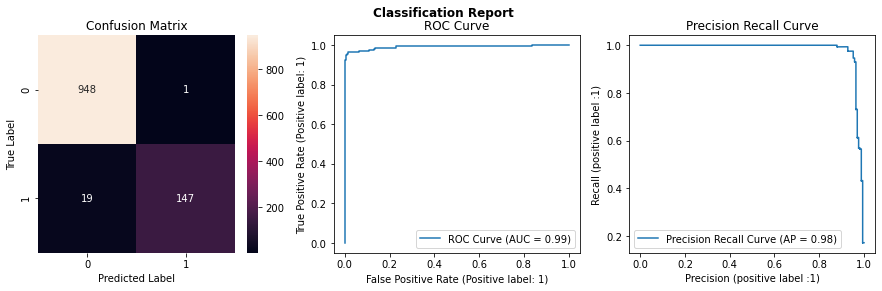

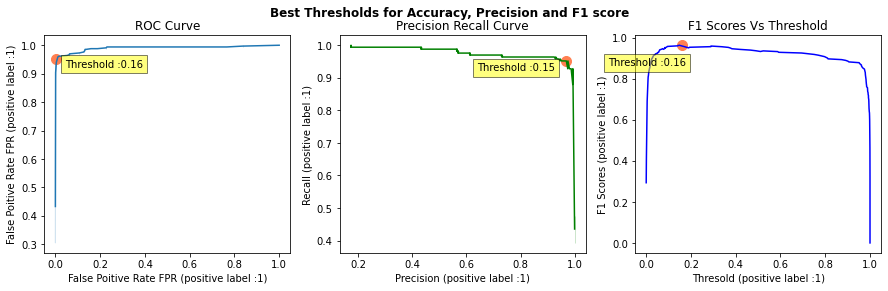

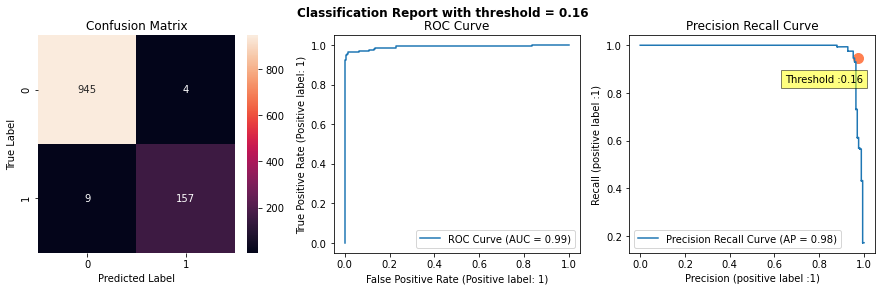

In [210]:
# Best Model Appears to be logistic Regression 
best_model = trained_models_cv['logistic_regression']
print('Classification Report \n')
evaluate_model(best_model,X_test,y_test)
print('\n')

# get the best Threshold for F1 score for Decsion makeing IF model output prediction probabilites
_,_,best_threshold = get_best_thresholds(best_model,X_test,y_test)

# Revaluate the model with best threshold
print('Classification Report')
print('Best Threshold :',round(best_threshold,2),'\n')
evaluate_model(best_model,X_test,y_test,threshold=best_threshold)
print('\n')

Best Model summary  
Vectorizer : BOW  
Model      : Logistic Regression

Evaluation Metrics : F1 score 
f1-score : 0.9602446483180428
threshold : 0.16


## BOW -CountVectorizer bi-grams

#### Train Test split

In [256]:
# Create BOW using countvectorizer and vectorize the messages
cv_bigram = CountVectorizer(ngram_range=(1,2),max_features=5000)
X= cv_bigram.fit_transform(clean_data.message).toarray()

# convert the label to numeric 
# spam =1 , ham =0
y=pd.get_dummies(clean_data.label)
y=y.iloc[:,1].values

# Train Test Split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [262]:
# save count_vectorizer model 
file_name = 'count_vectorizer_bigram'
save_trained_models(cv_bigram,file_name)

#### Build And Evaluate Model

In [257]:
# Train Multiple Models
trained_models_cv_bigram =train_models(ml_models,X_train,y_train,X_test,y_test)

# Save Models 
filename_cv_bigram_models= 'models_count_vect_bigram'
save_trained_models(trained_models_cv_bigram,filename_cv_bigram_models)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\harish\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.45701896 0.87617441 0.91895354 0.92822831 0.92585024]
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
# load models 
filename_cv_bigram_models= 'models_count_vect_bigram'
trained_models_cv_bigram = load_trained_models(filename_cv_bigram_models)

In [259]:
# Print Evaluation metrics 
print_cv_scores_gridsearch(trained_models_cv_bigram)

Grid Search results

Model            : naive_bayes
Best Parameters  : {'alpha': 0.1}
Cross Validation : 5
Mean Cross-validation f1-score : 0.9371646486801535
Model            : logistic_regression
Best Parameters  : {'C': 10}
Cross Validation : 5
Mean Cross-validation f1-score : 0.9282283122007764
Model            : svm
Best Parameters  : {'C': 10, 'gamma': 0.01}
Cross Validation : 5
Mean Cross-validation f1-score : 0.9188836694701639


#### Best Model

Classification Report 

Accuracy  : 0.9883408071748879
precision : 0.9811320754716981
recall    : 0.9397590361445783
f1score    : 0.9600000000000001
roc_auc   : 0.983438495816776


Classification Report
Best Threshold : 0.89 

Accuracy  : 0.989237668161435
precision : 0.9935897435897436
recall    : 0.9337349397590361
f1score    : 0.9627329192546583
roc_auc   : 0.983438495816776




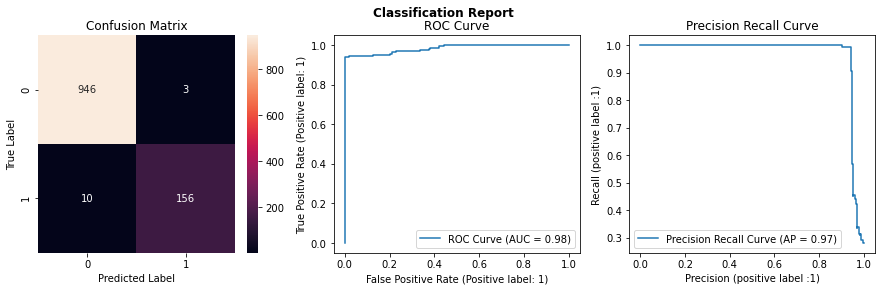

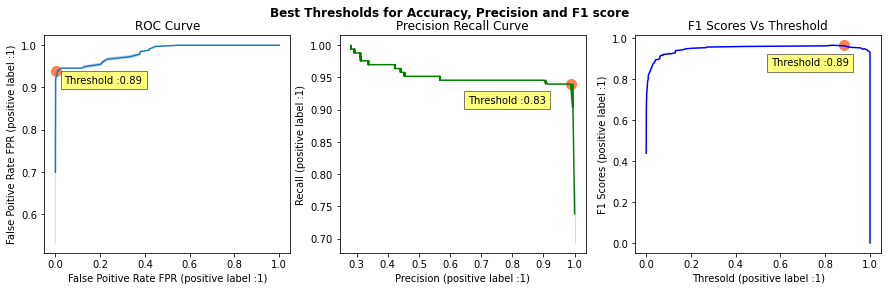

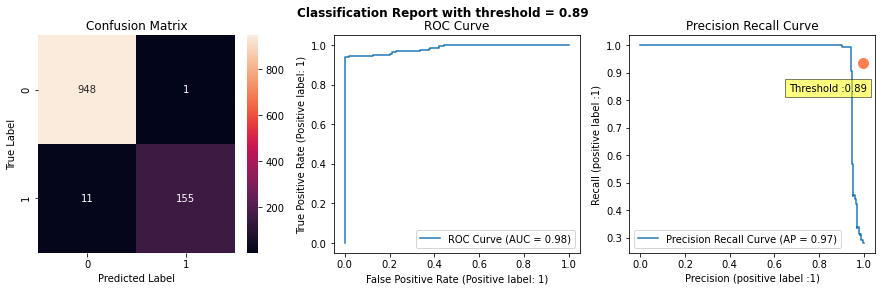

In [261]:
# Best Model Appears to be logistic Regression 
best_model = trained_models_cv_bigram['naive_bayes']
print('Classification Report \n')
evaluate_model(best_model,X_test,y_test)
print('\n')

# get the best Threshold for F1 score for Decsion makeing IF model output prediction probabilites
_,_,best_threshold = get_best_thresholds(best_model,X_test,y_test)

# Revaluate the model with best threshold
print('Classification Report')
print('Best Threshold :',round(best_threshold,2),'\n')
evaluate_model(best_model,X_test,y_test,threshold=best_threshold)
print('\n')

## TF-IDF Vectorizer 

### Train Test split

In [211]:
# Create BOW using countvectorizer and vectorize the messages
tfidf_v = TfidfVectorizer(max_features=5000,min_df=10)
X= tfidf_v.fit_transform(clean_data.message).toarray()

# convert the label to numeric 
# spam =1 , ham =0
y=pd.get_dummies(clean_data.label)
y=y.iloc[:,1].values

# Train Test Split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### Build and Evaluate Model

In [86]:
# Train Multiple Models
trained_models_tfidf =train_models(ml_models,X_train,y_train,X_test,y_test)

# Save Models 
filename_tfidf_models= 'models_tfidf_vect'
save_trained_models(trained_models_tfidf,filename_tfidf_models)

In [212]:
# load models 
filename_tfidf_models= 'models_tfidf_vect'
trained_models_tfidf = load_trained_models(filename_tfidf_models)

C:\Users\harish\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\harish\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\harish\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\harish\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator SVC from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code o

In [196]:

# Print Evaluation metrics 
print_cv_scores_gridsearch(trained_models_tfidf)

Grid Search results

Model            : naive_bayes
Best Parameters  : {'alpha': 0.1}
Cross Validation : 5
Mean Cross-validation f1-score : 0.9169973232290228
Model            : logistic_regression
Best Parameters  : {'C': 100}
Cross Validation : 5
Mean Cross-validation f1-score : 0.932911137157677
Model            : svm
Best Parameters  : {'C': 10, 'gamma': 0.1}
Cross Validation : 5
Mean Cross-validation f1-score : 0.9325077953620079


### Best Model 

Classification Report 

Accuracy  : 0.9865470852017937
precision : 0.9808917197452229
recall    : 0.927710843373494
f1score    : 0.9535603715170279
roc_auc   : 0.9896308098569199


Classification Report
Best Threshold : 0.51 

Accuracy  : 0.9856502242152466
precision : 0.9807692307692307
recall    : 0.9216867469879518
f1score    : 0.9503105590062112
roc_auc   : 0.9896308098569199




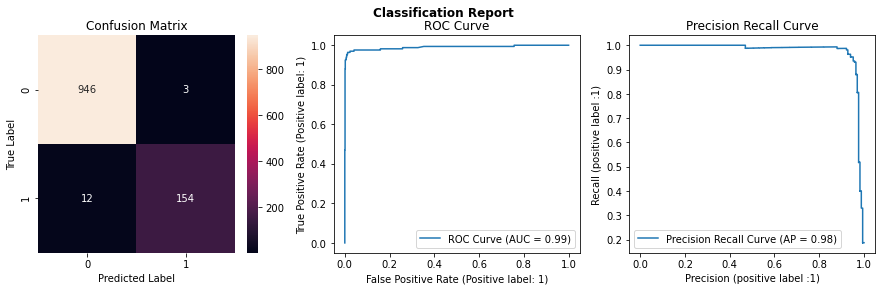

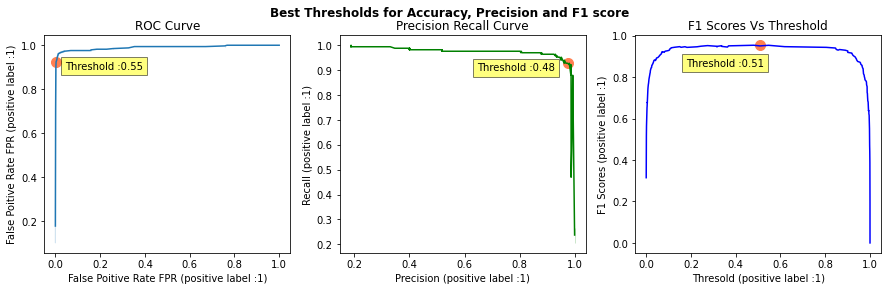

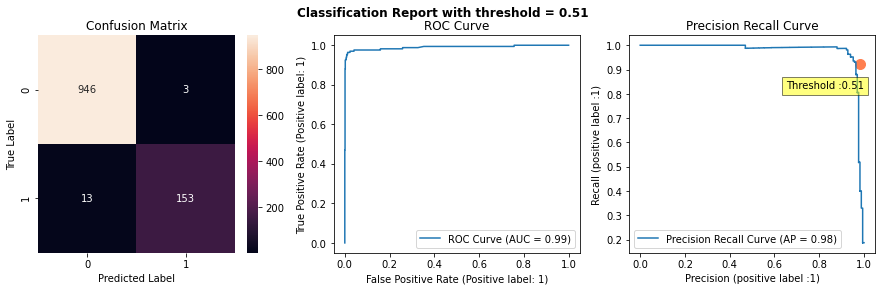

In [213]:
# Best Model Appears to be logistic Regression 
best_model = trained_models_tfidf['logistic_regression']
print('Classification Report \n')
evaluate_model(best_model,X_test,y_test)
print('\n')

# get the best Threshold for F1 score for Decsion makeing IF model output prediction probabilites
_,_,best_threshold = get_best_thresholds(best_model,X_test,y_test)

# Revaluate the model with best threshold
print('Classification Report')
print('Best Threshold :',round(best_threshold,2),'\n')
evaluate_model(best_model,X_test,y_test,threshold=best_threshold)
print('\n')

## Word2Vec 

### Setting up Models 

In [214]:
# Tune Model using Grid_search CV 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

ml_models = dict()

# Logistic_regression or Lasso rigression
lr_params = {'C':[0, 0.01,0.1, 1, 10, 100]}
lr_Grid_CV = GridSearchCV(LogisticRegression(),
                                       param_grid=lr_params,
                                       scoring='f1',
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=1
                                       )

# Naive bayes 
nb_params = {'alpha':[0, 0.01,0.1, 1, 10, 100]}
nb_Grid_CV = GridSearchCV(MultinomialNB(),
                                       param_grid=nb_params,
                                       scoring='f1',
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=1
                                       )

# SVM
svm_params = {'C':[0.01,0.1,1,10],
          'gamma':[0.01,0.1,1,10]
         }
svm_Grid_CV = GridSearchCV(SVC(),
                                       param_grid=svm_params,
                                       scoring='f1',
                                       cv=5,
                                       n_jobs=-1,
                                       verbose=1
                                       )

# Random Forest 

rf_params = {'min_samples_leaf':[1,2,3,4,5]}
rf_Grid_CV= GridSearchCV(RandomForestClassifier( ),
                         param_grid = rf_params,
                         scoring ='f1',
                         cv=5,
                         n_jobs=-1,
                         verbose =1)


#ml_models['naive_bayes']= nb_Grid_CV
ml_models['logistic_regression']=lr_Grid_CV
ml_models['svm']=svm_Grid_CV
ml_models['random_forest']=rf_Grid_CV

### Buld Vectors 

In [145]:
# convert sentenses() to list of words 

messages = []

for sentence in clean_data.message:
    words = sentence.split()
    messages.append(words)

In [146]:
from gensim.models import Word2Vec

w2vec_model = Word2Vec(messages,vector_size=100,min_count=2)

save_trained_models(w2vec_model,'Word2Vec_model')

In [215]:
# load Word2Vec model 
w2vec_model = load_trained_models('Word2Vec_model')

### Average Word to Vec 

In [147]:
def avgWord2Vec_from_sent(sentences,Word2Vec_model):
    '''
    Function returns the average of vectors of the words in the sentences.
    Input : sentence - list of sentences Tokenized format 
            Word2Vec_model - Trained Word2Vec models_count_vect
            
    Return : list of Vector representation of sentence - Average word2vec
    '''
    
    # Get the dimension of the vector of word in the vocab
    vocab_word = Word2Vec_model.wv.index_to_key[0]
    vector_dim = Word2Vec_model.wv[vocab_word].shape[0]
    
    # Vocab of words used for word2Vec Model 
    w2v_words = Word2Vec_model.wv.index_to_key
    
    
    sent_vectors =[];
    
    for sentence in sentences:  
        # Intialize sentence vector
        sentence_vector = np.zeros(vector_dim)

        # No of valid words with valid vector in sentence 
        count_words =0

        for word in sentence:
            if word in w2v_words:
                word_vector = Word2Vec_model.wv[word]
                sentence_vector += word_vector
                count_words +=1

        # Take the average 
        if count_words!=0:
            sentence_vector /=count_words
            
        # append sent to sentences 
        sent_vectors.append(list(sentence_vector))
    
    return sent_vectors



#### Train Test split

In [216]:
# convert all sms messages to avgword2vec 

X = np.array(avgWord2Vec_from_sent(messages,w2vec_model))

# convert the label to numeric 
# spam =1 , ham =0
y=pd.get_dummies(clean_data.label)
y=y.iloc[:,1].values

# Train Test Split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

#### Build and Evaluate 

In [149]:
# Train Multiple Models
trained_models_avg_w2v =train_models(ml_models,X_train,y_train,X_test,y_test)

# Save Models 
filename_avg_w2v_models= 'models_avg_w2v'
save_trained_models(trained_models_avg_w2v,filename_avg_w2v_models)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\harish\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.         0.         0.         0.46232872 0.76861762]
  warnings.warn(
C:\Users\harish\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [217]:
# load models 
trained_models_avg_w2v = load_trained_models('models_avg_w2v')

In [218]:
# Print Evaluation metrics 
print_cv_scores_gridsearch(trained_models_avg_w2v)

Grid Search results

Model            : logistic_regression
Best Parameters  : {'C': 100}
Cross Validation : 5
Mean Cross-validation f1-score : 0.7686176171013593
Model            : svm
Best Parameters  : {'C': 10, 'gamma': 10}
Cross Validation : 5
Mean Cross-validation f1-score : 0.8582877953617153
Model            : random_forest
Best Parameters  : {'min_samples_leaf': 1}
Cross Validation : 5
Mean Cross-validation f1-score : 0.8663263899284785


####  Best Model on Test data

In [224]:
# Best Model Appears to be Random Forest  
best_model = trained_models_avg_w2v['random_forest']
print_evaluation_metrics_single(best_model,X_test,y_test,model_name='random_forest')


Classification Report
Model Name        : random_forest
Best Parameters   : {'min_samples_leaf': 1}
Test data metrics :
{'accuracy': 0.9506726457399103,
 'f1-score': 0.8122866894197951,
 'precision': 0.937007874015748,
 'recall': 0.7168674698795181}


### TF_IDF weighted Word2Vec

In [163]:
def tfidf_wighted_Word2Vec_from_sent(sentences,Word2Vec_model,tf_idf_model):
    '''
    Function returns the  tf-idf weighted average of vectors of the words in the sentences.
    Input : sentence - list of sentences Tokenized format 
            Word2Vec_model - Trained Word2Vec models_count_vect
            tf_idf_model - tf-idf model trained on corpus 
            
    Return : list of Vector representation of sentence - tf-idf weighted average of vectors
    '''
    
    # create dictionary of word as key and tf-idf as value 
    idf_dictionary = dict(zip(tf_idf_model.get_feature_names(),list(tf_idf_model.idf_)))
    
    # TF-IDF weighted Word2Vec
    tfidf_feat = tf_idf_model.get_feature_names() # tfidf words/col-names
    
    # Get the dimension of the vector of word in the vocab
    vocab_word = Word2Vec_model.wv.index_to_key[0]
    vector_dim = Word2Vec_model.wv[vocab_word].shape[0]
    
    # Vocab of words used for word2Vec Model 
    w2v_words = Word2Vec_model.wv.index_to_key
    
    
    sent_vectors =[];
    
    for sentence in sentences:  
        # Intialize sentence vector
        sentence_vector = np.zeros(vector_dim)

        # No of valid words with valid vector in sentence 
        weight_sum =0

        for word in sentence:
            if word in w2v_words and word in tfidf_feat:
                word_vector = Word2Vec_model.wv[word]
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf = sentence.count(word)/len(sentence)
                idf = idf_dictionary[word]
                tf_idf = tf*idf
                
                sentence_vector += (word_vector*tf_idf)
                weight_sum +=tf_idf

        # Take the average 
        if weight_sum!=0:
            sentence_vector /=weight_sum
            
        # append sent to sentences 
        sent_vectors.append(list(sentence_vector))
    
    return sent_vectors

#### Train Test Split

In [161]:
# calculate TF-IDF weights 

tfidf = TfidfVectorizer()
tfidf.fit(clean_data.message)



TfidfVectorizer()

In [225]:

# convert all sms messages to tfidf weighted word2vec 

X = np.array(tfidf_wighted_Word2Vec_from_sent(messages,w2vec_model,tfidf))

# convert the label to numeric 
# spam =1 , ham =0
y=pd.get_dummies(clean_data.label)
y=y.iloc[:,1].values

# Train Test Split 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

#### Buld and Evaluate 

In [165]:
# Train Multiple Models
trained_models_tfidf_w2v =train_models(ml_models,X_train,y_train,X_test,y_test)

# Save Models 
filename_tfidf_w2v_models= 'models_tfidf_w2v'
save_trained_models(trained_models_tfidf_w2v,filename_tfidf_w2v_models)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\harish\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.         0.         0.         0.37773424 0.71634558]
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [226]:
# load models 
trained_models_tfidf_w2v = load_trained_models('models_tfidf_w2v')

In [227]:

# Print Evaluation metrics 
print_cv_scores_gridsearch(trained_models_tfidf_w2v)

Grid Search results

Model            : logistic_regression
Best Parameters  : {'C': 100}
Cross Validation : 5
Mean Cross-validation f1-score : 0.7163455814830334
Model            : svm
Best Parameters  : {'C': 10, 'gamma': 10}
Cross Validation : 5
Mean Cross-validation f1-score : 0.8473058913572642
Model            : random_forest
Best Parameters  : {'min_samples_leaf': 1}
Cross Validation : 5
Mean Cross-validation f1-score : 0.8133845741148574


#### Best Model - Test Data

In [229]:
# Best Model Appears to be svm  
best_model = trained_models_avg_w2v['svm']
print_evaluation_metrics_single(best_model,X_test,y_test,model_name='svm')

Classification Report
Model Name        : svm
Best Parameters   : {'C': 10, 'gamma': 10}
Test data metrics :
{'accuracy': 0.9372197309417041,
 'f1-score': 0.75177304964539,
 'precision': 0.9137931034482759,
 'recall': 0.6385542168674698}


# Summary 

## Save Best Model

In [230]:
best_model = trained_models_cv['logistic_regression']
save_trained_models(best_model,'best_model_lr')

Below is the Model details which Performed best on Test Data

Best Model  : Logisitic Regression  
Vectorizer  : BOW-Count vectorizer   

Evaluation Metrics : f1 score   
f1-score : 0.960  
Best Threshold : 0.16   

Classification Report :  
Accuracy  : 0.9883408071748879  
precision : 0.9751552795031055  
recall    : 0.9457831325301205  
f1score    : 0.9602446483180428  
roc_auc   : 0.9907004202267446  


In [263]:
best_model1 = trained_models_cv_bigram['naive_bayes']
save_trained_models(best_model1,'best_model_ngram_nb')